In [1]:
#import statements here
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import functions as sf
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.feature import RegexTokenizer
import requests
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import concat, col, lit, lower
from pyspark.sql.functions import isnan, when, count, col, isnull
from pyspark.sql.functions import concat_ws
from  pyspark.sql.functions import abs
# seting master("local[*]") enables multicore processing on all available logical cores on your machine
#spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder \
.appName('app_name') \
.master('local[*]') \
.config('spark.sql.execution.arrow.pyspark.enabled', True) \
.config('spark.sql.session.timeZone', 'UTC') \
.config('spark.driver.memory','30G') \
.config("spark.driver.maxResultSize", "16g") \
.config('spark.ui.showConsoleProgress', True) \
.config('spark.sql.repl.eagerEval.enabled', True) \
.getOrCreate()
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml import evaluation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import evaluation
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [2]:
import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = r"C:\Users\srika\Dropbox\PC\Downloads\flight-delays-and-twitter-master\flight-delays-and-twitter-master\data" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [3]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
bdf = pd.read_csv(r'C:\Users\srika\Dropbox\PC\Downloads\flight-delays-and-twitter-master\flight-delays-and-twitter-master\data\hadoop.csv')

In [4]:
bdf.columns

Index(['Unnamed: 0', 'FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled',
       'Diverted', 'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay',
       'ArrTime', 'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime',
       'ActualElapsedTime', 'Distance', 'Year', 'Quarter', 'Month',
       'DayofMonth', 'DayOfWeek', 'Marketing_Airline_Network',
       'Operated_or_Branded_Code_Share_Partners', 'DOT_ID_Marketing_Airline',
       'IATA_Code_Marketing_Airline', 'Flight_Number_Marketing_Airline',
       'Operating_Airline', 'DOT_ID_Operating_Airline',
       'IATA_Code_Operating_Airline', 'Tail_Number',
       'Flight_Number_Operating_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName',
       'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15',
       'DepartureDelayGroups', 

In [5]:
#column_list1=["IATA_Code_Marketing_Airline", "Airline"]
column_list2=["IATA_Code_Marketing_Airline", "OriginCityName","OriginState"]
column_list3=["Year","Month","DayofMonth","DayOfWeek","Airline","Flight_Number_Marketing_Airline","Tail_Number","Origin", "Dest","CRSDepTime","DepTime","DepDelay","TaxiOut","WheelsOff","CRSElapsedTime","ActualElapsedTime","AirTime","Distance","WheelsOn", "TaxiIn","CRSArrTime","ArrTime","ArrDelay","Diverted","Cancelled","Flight_Number_Operating_Airline",]
#filter the dataframe beforehand
#bdf[column_list].to_csv('output.csv',index=False)

#or use columns arg
#bdf.to_csv('airlines.csv', columns = column_list,index=False)
bdf.to_csv('airports.csv', columns = column_list2,index=False)
bdf.to_csv('flights.csv', columns = column_list3,index=False) 

In [4]:
#load the files
airlines_df = spark.read.csv(get_training_filename(r'C:\Users\srika\Dropbox\PC\Downloads\flight-delays-and-twitter-master\flight-delays-and-twitter-master\airlines.csv'), header=True, inferSchema=True)
airports_df = spark.read.csv(get_training_filename(r'C:\Users\srika\Dropbox\PC\Downloads\flight-delays-and-twitter-master\flight-delays-and-twitter-master\airports.csv'), header=True, inferSchema=True)
flight_df = spark.read.csv(get_training_filename(r'C:\Users\srika\Dropbox\PC\Downloads\flight-delays-and-twitter-master\flight-delays-and-twitter-master\flights.csv'), header=True, inferSchema=True)

In [5]:
airlines_df.columns

['Code', 'Description']

In [6]:
airports_df.columns

['IATA_Code_Marketing_Airline', 'OriginCityName', 'OriginState']

In [7]:
flight_df.columns

['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'Airline',
 'Flight_Number_Marketing_Airline',
 'Tail_Number',
 'Origin',
 'Dest',
 'CRSDepTime',
 'DepTime',
 'DepDelay',
 'TaxiOut',
 'WheelsOff',
 'CRSElapsedTime',
 'ActualElapsedTime',
 'AirTime',
 'Distance',
 'WheelsOn',
 'TaxiIn',
 'CRSArrTime',
 'ArrTime',
 'ArrDelay',
 'Diverted',
 'Cancelled']

In [8]:
flights_df = flight_df.selectExpr("Year as YEAR","DayofMonth as DAY","Month as MONTH","DayOfWeek as DAY_OF_WEEK","Airline as AIRLINE","Origin as ORIGIN_AIRPORT","ArrDelay as ARRIVAL_DELAY","Dest as DESTINATION_AIRPORT","CRSDepTime as SCHEDULED_DEPARTURE","DepDelay as DEPARTURE_DELAY","CRSArrTime as SCHEDULED_ARRIVAL","Cancelled as CANCELLED","Distance as DISTANCE")
flights_df.show()

+----+---+-----+-----------+-----------------+--------------+-------------+-------------------+-------------------+---------------+-----------------+---------+--------+
|YEAR|DAY|MONTH|DAY_OF_WEEK|          AIRLINE|ORIGIN_AIRPORT|ARRIVAL_DELAY|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_DELAY|SCHEDULED_ARRIVAL|CANCELLED|DISTANCE|
+----+---+-----+-----------+-----------------+--------------+-------------+-------------------+-------------------+---------------+-----------------+---------+--------+
|2018| 23|    1|          2|Endeavor Air Inc.|           ABY|         -8.0|                ATL|               1202|           -5.0|             1304|    false|   145.0|
|2018| 24|    1|          3|Endeavor Air Inc.|           ABY|         -6.0|                ATL|               1202|           -5.0|             1304|    false|   145.0|
|2018| 25|    1|          4|Endeavor Air Inc.|           ABY|         -2.0|                ATL|               1202|           -9.0|             1304|    fa

In [9]:
flights_df.columns

['YEAR',
 'DAY',
 'MONTH',
 'DAY_OF_WEEK',
 'AIRLINE',
 'ORIGIN_AIRPORT',
 'ARRIVAL_DELAY',
 'DESTINATION_AIRPORT',
 'SCHEDULED_DEPARTURE',
 'DEPARTURE_DELAY',
 'SCHEDULED_ARRIVAL',
 'CANCELLED',
 'DISTANCE']

The shape of flights_df: (29193782, 13)
+----+---+-----+-----------+-------+--------------+-------------+-------------------+-------------------+---------------+-----------------+---------+--------+
|YEAR|DAY|MONTH|DAY_OF_WEEK|AIRLINE|ORIGIN_AIRPORT|ARRIVAL_DELAY|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_DELAY|SCHEDULED_ARRIVAL|CANCELLED|DISTANCE|
+----+---+-----+-----------+-------+--------------+-------------+-------------------+-------------------+---------------+-----------------+---------+--------+
|   0|  0|    0|          0|      0|             0|       846183|                  0|                  0|         763084|                0|        0|       0|
+----+---+-----+-----------+-------+--------------+-------------+-------------------+-------------------+---------------+-----------------+---------+--------+

root
 |-- YEAR: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |--

C:\Users\srika\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\srika\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\srika\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

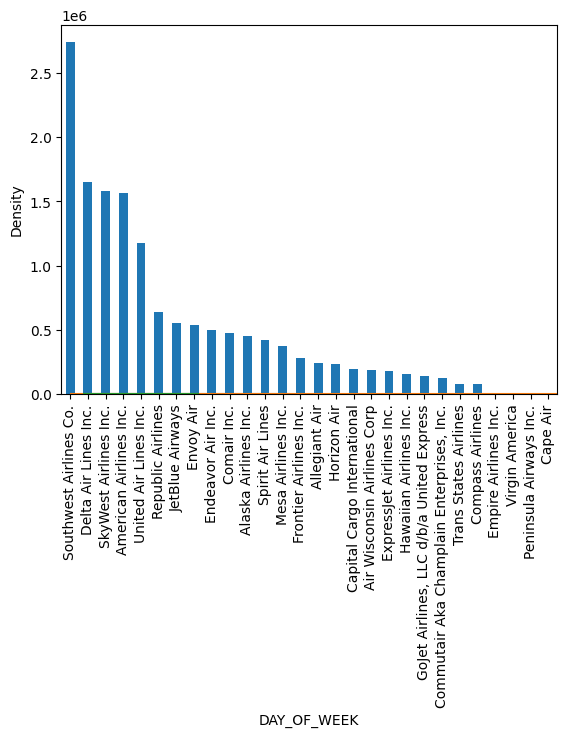

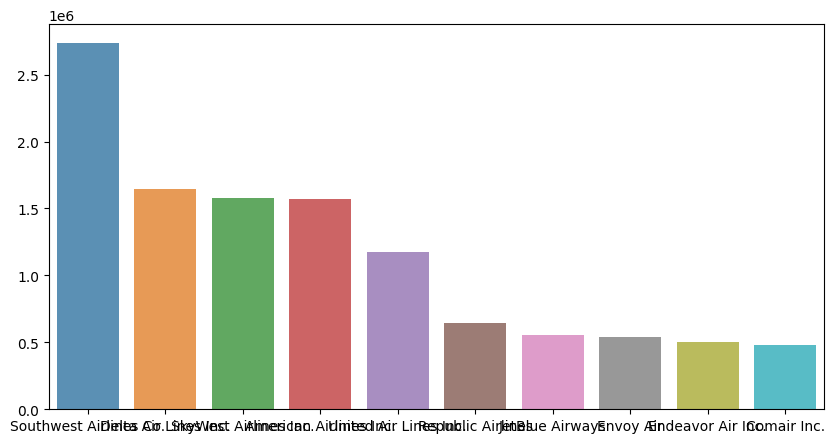

In [10]:
#EDA

shape = ((flights_df.count(), len(flights_df.columns)))  #prints the shape
print('The shape of flights_df:', shape)

print(flights_df.select([count(when(isnull(c), c)).alias(c) for c in flights_df.columns])) # prints the null values in the columns

print(flights_df.printSchema())  #shows the schema of the datasset

flights_df_sample = flights_df.sample(True, 0.5, 42)
flights_df_sample_pandas = flights_df_sample.toPandas() #create sample for being able to create proper visualizations on the dataset

#create visualizations for relevant features to understand the data
sns.distplot(flights_df_sample_pandas['MONTH'])
display()

sns.distplot(flights_df_sample_pandas['DAY'])
display()


sns.distplot(flights_df_sample_pandas['DAY_OF_WEEK'])
display()


flights_df_sample_pandas['AIRLINE'].value_counts().plot(kind='bar')
display()

airline_count  = flights_df_sample_pandas['AIRLINE'].value_counts()
airline_count = airline_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(airline_count.index, airline_count.values, alpha=0.8)
display()



C:\Users\srika\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\srika\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\srika\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWa

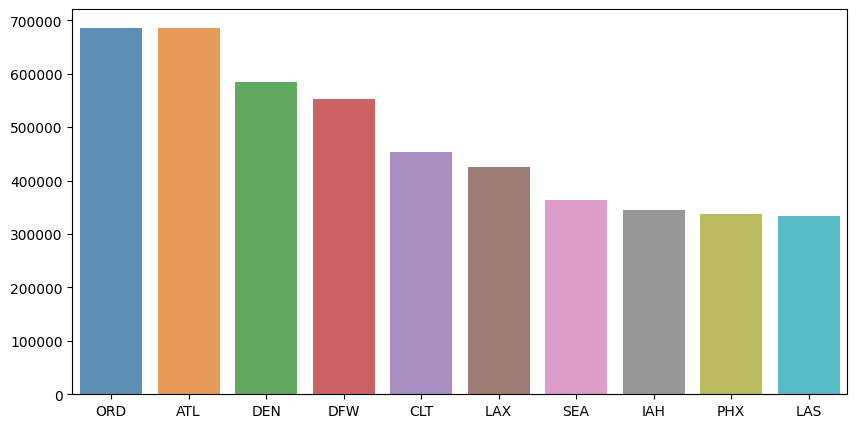

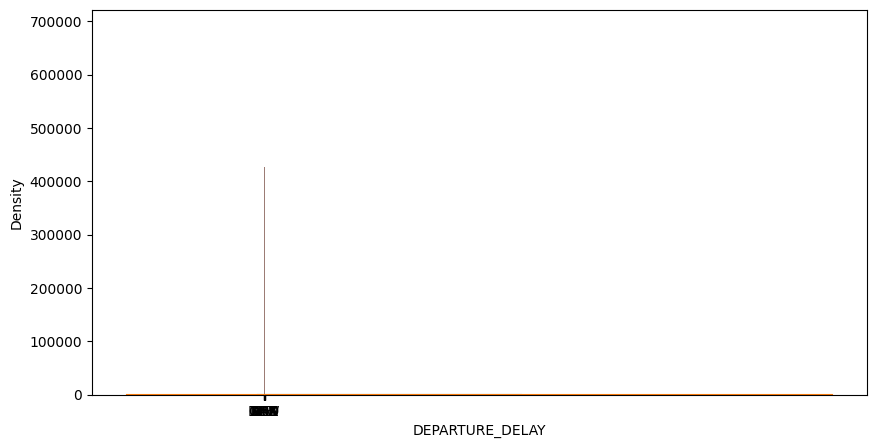

In [11]:
#create visualizations for relevant features to understand the data
oa_count  = flights_df_sample_pandas['ORIGIN_AIRPORT'].value_counts()
oa_count = oa_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(oa_count.index, oa_count.values, alpha=0.8)
display()

da_count  = flights_df_sample_pandas['DESTINATION_AIRPORT'].value_counts()
da_count = da_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(da_count.index, da_count.values, alpha=0.8)
display()


sns.distplot(flights_df_sample_pandas['SCHEDULED_DEPARTURE'])
display()


sns.distplot(flights_df_sample_pandas['DEPARTURE_DELAY'])
display()

C:\Users\srika\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\srika\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


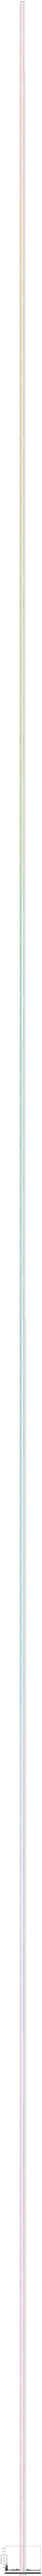

In [12]:
#create visualizations for relevant features to understand the data
sns.distplot(flights_df_sample_pandas['DISTANCE'])
display()

sns.distplot(flights_df_sample_pandas['SCHEDULED_ARRIVAL'])
display()

sns.barplot(x="MONTH", y="DEPARTURE_DELAY", data=flights_df_sample_pandas)
display()


df3 = flights_df.groupBy('MONTH').avg('DEPARTURE_DELAY').toPandas()
df3
fig4 = sns.barplot(x = 'MONTH', y = 'avg(DEPARTURE_DELAY)', data = df3)
display()

sns.barplot(x="AIRLINE", y="DEPARTURE_DELAY", hue="DISTANCE", data=flights_df_sample_pandas)
display()

sns.barplot(x="SCHEDULED_DEPARTURE", y="DEPARTURE_DELAY", data=flights_df_sample_pandas)
display()


sns.barplot(x="ORIGIN_AIRPORT", y="DEPARTURE_DELAY", data=flights_df_sample_pandas)
display()


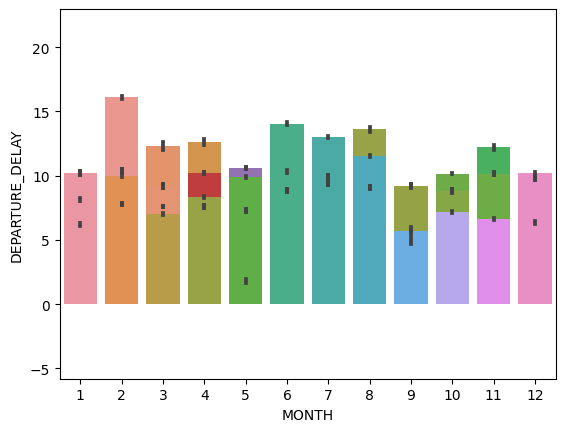

In [13]:
#create visualizations for relevant features to understand the data
sns.barplot(x="AIRLINE", y="DEPARTURE_DELAY", data=flights_df_sample_pandas)
display()


sns.barplot(x="DAY_OF_WEEK", y="DEPARTURE_DELAY", data=flights_df_sample_pandas)
display()


sns.barplot(x="DAY_OF_WEEK", y="DEPARTURE_DELAY", data=flights_df_sample_pandas)
display()

sns.barplot(x="DAY", y="DEPARTURE_DELAY",  data=flights_df_sample_pandas)
display()

sns.barplot(x="DAY", y="DEPARTURE_DELAY", data=flights_df_sample_pandas)
display()

sns.barplot(x="MONTH", y="DEPARTURE_DELAY",  data=flights_df_sample_pandas)
display()

In [16]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
#DATA PREPARATION: now we will process the dataset and convert into a usable dataset

#create dataframe with columns we will consider
flights_df = flights_df.select('MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', 'DISTANCE', 'SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY', 'CANCELLED')  

#remove columns with cancel = 0 
flights_df = flights_df.filter((fn.col('CANCELLED')==0))

#set up a threshold for the delay time
flights_df = flights_df.withColumn("Flight_Delayed", fn.when(fn.col("DEPARTURE_DELAY")<15, 0).otherwise(1))

#create buckets for distance as long, short and medium
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import udf
from pyspark.sql.types import *
bucketizer = Bucketizer(splits=[ 0, 100, 1000, float('Inf') ],inputCol="DISTANCE", outputCol="Distance_Bucket")
bucketizer = encoder.fit(flights_df)
flights_df = bucketizer.setHandleInvalid("keep").transform(flights_df)
t = {0.0:"Short", 1.0: "Medium", 2.0:"Long"}
udf_foo = udf(lambda x: t[x], StringType())
flights_df = flights_df.withColumn("Flight_Distance", udf_foo("Distance_Bucket"))

#perform string index, which prevents creation of new columns for the dummy variables and perform one hot encoding
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

indexer = StringIndexer(inputCol="AIRLINE", outputCol="Airline_Numeric").fit(flights_df)
flights_df = indexer.transform(flights_df)


encoder = OneHotEncoder(inputCol="Airline_Numeric", outputCol="Airline_OHE")
flights_df= encoder.transform(flights_df)

indexer = StringIndexer(inputCol="ORIGIN_AIRPORT", outputCol="OA_Numeric").fit(flights_df)
flights_df = indexer.transform(flights_df)

encoder = OneHotEncoder(inputCol="OA_Numeric", outputCol="Origin_Airport_OHE")
flights_df= encoder.transform(flights_df)

indexer = StringIndexer(inputCol="DESTINATION_AIRPORT", outputCol="DA_Numeric").fit(flights_df)
flights_df = indexer.transform(flights_df)

encoder = OneHotEncoder(inputCol="DA_Numeric", outputCol="Destination_Airport_OHE")
flights_df= encoder.transform(flights_df)

flights_df = flights_df.drop('ARRIVAL_DELAY')

IllegalArgumentException: Airline_Numeric does not exist. Available: MONTH, DAY, DAY_OF_WEEK, AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT, SCHEDULED_DEPARTURE, DEPARTURE_DELAY, DISTANCE, SCHEDULED_ARRIVAL, ARRIVAL_DELAY, CANCELLED, Flight_Delayed

In [ ]:
#that dataset is imbalanced

#perform undersampling for the preparation of the data
#split the train test data
training_df, testing_df = flights_df.randomSplit([0.9, 0.1], seed=5)

#create major and minor DF 
major_df = training_df.filter(col("Flight_Delayed") == 0)
minor_df = training_df.filter(col("Flight_Delayed") == 1)
ratio = major_df.count()/minor_df.count()

#create the balanced dataset for training the model
sampled_majority_df = major_df.sample(False, 1.2/ratio, seed=5)
combined_df_2 = sampled_majority_df.unionAll(minor_df)

#shows the count of balanced dataframe
combined_df_2.groupBy('Flight_Delayed').agg(fn.count('*')).show()

In [ ]:
#implementation of prepared and undersampled dataset for the model implementation

#create a vector assembler
va = VectorAssembler(
    inputCols=["MONTH", "DAY", "DAY_OF_WEEK", "Airline_OHE", "Origin_Airport_OHE", "Destination_Airport_OHE", "SCHEDULED_DEPARTURE", "Distance_Bucket", "SCHEDULED_ARRIVAL", "CANCELLED"], outputCol="features")

#train a logistic model
lr = LogisticRegression(featuresCol='features', labelCol='Flight_Delayed', regParam=0.2, elasticNetParam=0.1, threshold=0.45, thresholds=[0.55, 0.45])
lr_pipeline = Pipeline(stages=[va, lr])
lr_model = lr_pipeline.fit(combined_df_2)
lr_transform = lr_model.transform(testing_df)

#logistic model metric evaluation

#AUC score
bce = BinaryClassificationEvaluator(labelCol='Flight_Delayed', metricName='areaUnderROC')
score_auc=bce.evaluate(lr_transform)

#Recall
lr_evaluator_recall = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="weightedRecall")
score_recall=lr_evaluator_recall.evaluate(lr_model.transform(testing_df))

#Precision
lr_evaluator_precision = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="weightedPrecision")
score_precision=lr_evaluator_precision.evaluate(lr_model.transform(testing_df))

#accuracy
lr_evaluator_accuracy = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="accuracy")
score_accuracy=lr_evaluator_accuracy.evaluate(lr_model.transform(testing_df))

#f1 
lr_evaluator_accuracy = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="f1")
score_f1=lr_evaluator_accuracy.evaluate(lr_model.transform(testing_df))

#shows the scatterplot
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'r--')
plt.scatter(lr_model.stages[-1].summary.roc.select('FPR').collect(),
            lr_model.stages[-1].summary.roc.select('TPR').collect())
plt.title('ROC Scatter Plot : TPR/FPR')
plt.xlabel('FPR')
plt.ylabel('TPR')
display()

In [ ]:
#
scores = [score_auc, score_recall, score_accuracy, score_f1, score_precision]
metricName = ['AUC', 'Recall', 'Accuracy', 'f1', 'Precision']
metric_df = pd.DataFrame(zip(metricName,scores),index=[1,2,3,4,5],columns=['Metric Name', 'Score'])
metric_df.head(5)

In [ ]:
#Confusion matrix of logistic regression

y_true = lr_transform.select(['Flight_Delayed']).collect()
y_pred = lr_transform.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

In [ ]:
#train the GBT model on the balanced dataset
gbt = GBTClassifier(featuresCol='features', labelCol='Flight_Delayed', maxIter=5, maxBins=15, stepSize=0.08, maxDepth=4)
gbt_pipeline = Pipeline(stages=[va, gbt])
gbt_model = gbt_pipeline.fit(combined_df_2)
gbt_transform = gbt_model.transform(testing_df)

#evaluation metric for GBT
gbt_bce = BinaryClassificationEvaluator(labelCol='Flight_Delayed', metricName='areaUnderROC')
score_auc=gbt_bce.evaluate(gbt_transform)

#f1
gbt_evaluator_f1 = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="f1")
score_f1=gbt_evaluator_f1.evaluate(gbt_transform)

#accuracy
gbt_evaluator_accuracy = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="accuracy")
score_accuracy=gbt_evaluator_accuracy.evaluate(gbt_transform)

#precision
gbt_evaluator_precision = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="weightedPrecision")
score_precision=gbt_evaluator_precision.evaluate(gbt_transform)

#recall
gbt_evaluator_recall = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="weightedRecall")
score_recall=gbt_evaluator_recall.evaluate(gbt_transform)

#dataframe for the evaluation metric
scores = [score_auc, score_recall, score_accuracy, score_f1, score_precision]
metricName = ['AUC', 'Recall', 'Accuracy', 'f1', 'Precision']

metric_df = pd.DataFrame(zip(metricName,scores),index=[1,2,3,4,5],columns=['Metric Name', 'Score'])
metric_df

In [ ]:
#Confusion matrix of logistic regression

y_true = gbt_transform.select(['Flight_Delayed']).collect()
y_pred = gbt_transform.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

In [ ]:
#create a further sample due to computation limit
sample = combined_df_2.sample(True, 0.2,seed=5)

#uncomment below comment if the error says label exists and run

# flights_df = flights_df.drop('label')
# training_df = training_df.drop('label')
# testing_df = testing_df.drop('label')
# sample = sample.drop('label')

features = sample.columns
sample = sample.select(col("Flight_Delayed").alias("label"), *features)

#perform train test to get the testing dataset
training_df, testing_df = flights_df.randomSplit([0.9, 0.1], seed=5)

#create vectorassembler 
va = VectorAssembler(inputCols=["MONTH", "DAY", "DAY_OF_WEEK", "Airline_OHE", "Origin_Airport_OHE", "Destination_Airport_OHE", "SCHEDULED_DEPARTURE", "Distance_Bucket", "SCHEDULED_ARRIVAL", "CANCELLED"], outputCol="unscaled_features")

#standardize the input
standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

#train model and create pipeline with crossvalidation
rf = RandomForestClassifier(featuresCol='features', labelCol='label')
rf_pipeline = Pipeline(stages=[va,standardScaler, rf])


paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [3,4]) \
    .addGrid(rf.numTrees, [100,150]) \
    .addGrid(rf.impurity,["Gini"]) \
    .addGrid(rf.featureSubsetStrategy,["auto", "sqrt"]) \
    .addGrid(rf.maxBins,[100]) \
    .build()
crossval_rf = CrossValidator(estimator=rf_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

cvModel = crossval_rf.fit(sample)

In [ ]:
#evaluation metric for random forest
testing_df = testing_df.select(col("Flight_Delayed").alias("label"), *features)
prediction = cvModel.transform(testing_df)

#AUC evaluation
bce = BinaryClassificationEvaluator(labelCol='label')
score_auc = bce.evaluate(prediction, {bce.metricName: "areaUnderROC"} )

#weighted precision
mce = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="weightedPrecision")
score_precision = mce.evaluate(cvModel.transform(testing_df))

#weighted Recall
mce = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="weightedRecall")
score_recall = mce.evaluate(cvModel.transform(testing_df))

#Accuracy
mce = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="accuracy")
score_accuracy = mce.evaluate(cvModel.transform(testing_df))

#f1
mce = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="f1")
score_f1= mce.evaluate(cvModel.transform(testing_df))

#dataframe for the evaluation metric
scores = [score_auc, score_recall, score_accuracy, score_f1, score_precision]
metricName = ['AUC', 'Recall', 'Accuracy', 'f1', 'Precision']

metric_df = pd.DataFrame(zip(metricName,scores),index=[1,2,3,4,5],columns=['Metric Name', 'Score'])
metric_df

In [ ]:
cols = ["MONTH", "DAY", "DAY_OF_WEEK", "Airline_OHE", "Origin_Airport_OHE", "Destination_Airport_OHE", "SCHEDULED_DEPARTURE", "Distance_Bucket", "SCHEDULED_ARRIVAL"]

randomForest_model = cvModel.bestModel.stages[-1]
RF_df = pd.DataFrame(list(zip(cols, randomForest_model.featureImportances.toArray())),
             columns = ['column', 'weight']).sort_values('weight', ascending=False)
RF_df